In [1]:
#%load /Users/gully/astroML/bombcat/DFM_GP_example.py

##Author: gully
##Date:   Mar 24 16:35:28 2014
###Updated:  Jan 6, 2015
#Desc:   Gaussian Process example

Originals available at:
https://github.com/dfm/gp-tutorial
&
https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes


In [1]:
%pylab inline
# Auto imports np and plt

Populating the interactive namespace from numpy and matplotlib


In [7]:
%config InlineBackend.figure_format = 'retina'

In [8]:
from matplotlib import rcParams
#rcParams["savefig.dpi"] = 150
import emcee  # http://dan.iel.fm/emcee
import triangle  # https://github.com/dfm/triangle.py
import numpy as np
import matplotlib.pyplot as plt
from astroML.plotting import hist
from astroML.stats.random import bivariate_normal
from matplotlib.patches import Ellipse
import timeit
#from IPython.display import display, Math, Latex

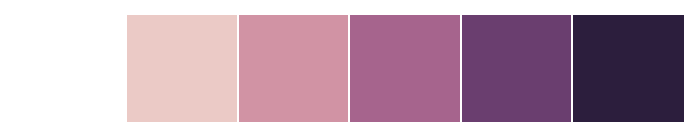

In [9]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.palplot(sns.cubehelix_palette(light=1))

## First we construct the data.
50 ($x$, $y$) points with errors $\epsilon$.

We also constuct and apply the covariance matrix.

In [10]:
np.random.seed(123456)

#First, build the "true" dataset with N=50 datapoints from a line model y=mx+b.
true_m, true_b = 0.5, -0.25
N = 50
x = np.linspace(-5, 5, N)
y = true_m * x + true_b

#Introduce some noise with both measurement uncertainties 
#   and non-trivial correlated errors.
yerr = 0.1 + 0.4 * np.random.rand(N)
yerr_hom = 0.4*np.ones(N)
hom_cov = np.diag(yerr_hom ** 2)
iid_cov = np.diag(yerr ** 2)
true_cov = 0.5 * np.exp(-0.5 * (x[:, None]-x[None, :])**2 / 1.3**2) + np.diag(yerr ** 2)
y = np.random.multivariate_normal(y, true_cov)
#y = np.random.multivariate_normal(y, iid_cov)

In [11]:
#plt.hist(yerr, normed=True, histtype='stepfilled', alpha=0.4);
#plt.xlabel('$\epsilon$');

##Plot II: Make a heatmap of the covariance matrix

The key idea about the covariance matrix is that the on-diagonal terms are the variances (*i.e.* $\sigma^2$) of the data points, whereas the off-diagonal terms demonstrate the extent to which neighboring values are correlated.

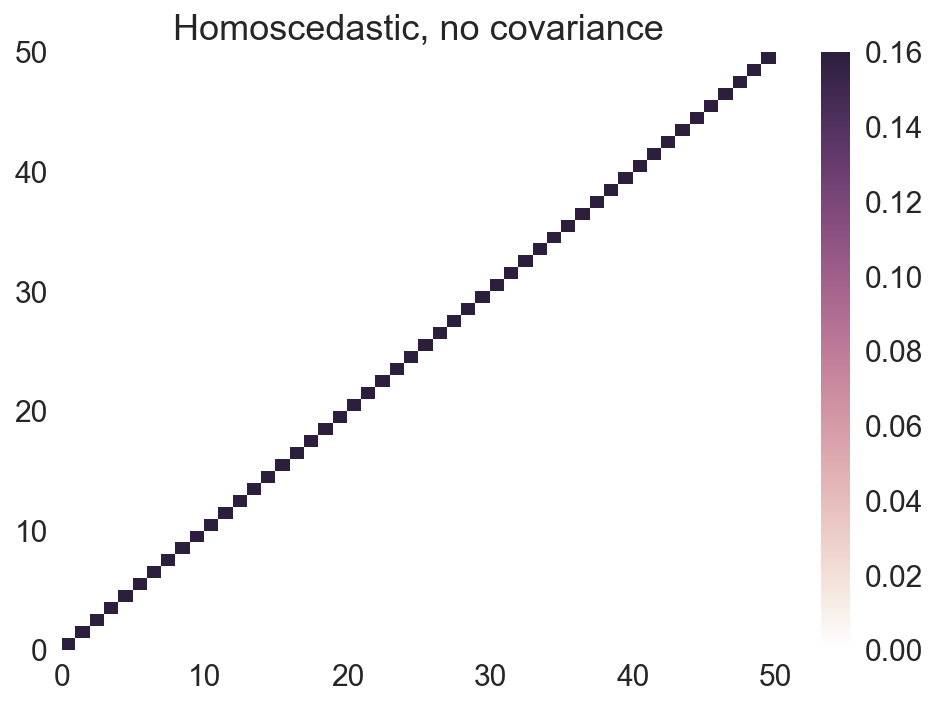

In [12]:
plt.pcolormesh(hom_cov, cmap=cmap);
plt.colorbar();
plt.title('Homoscedastic, no covariance')

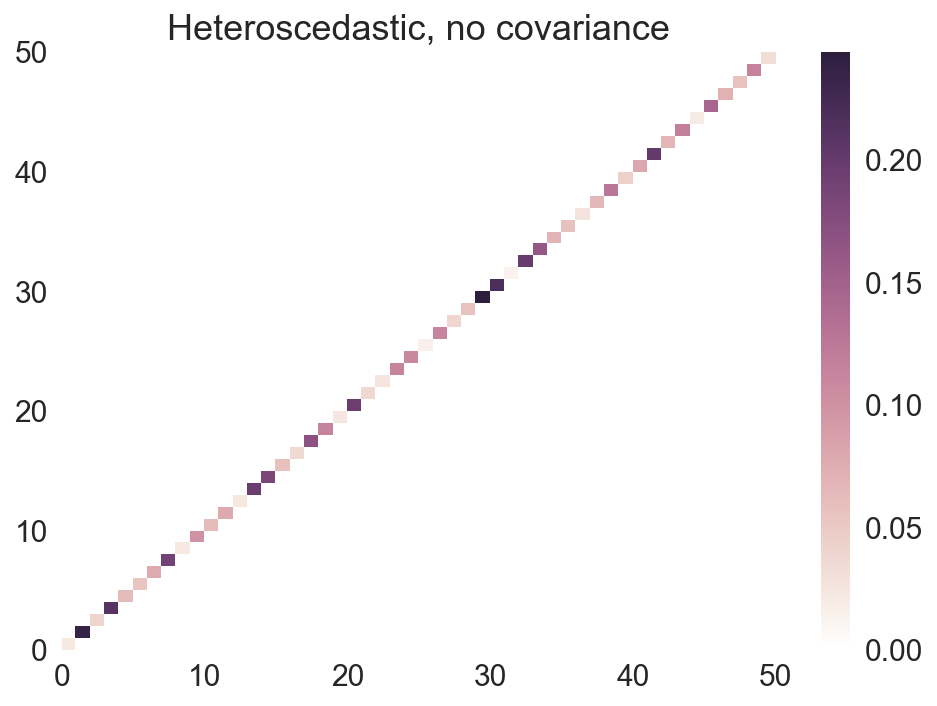

In [13]:
plt.pcolormesh(iid_cov, cmap=cmap);
plt.colorbar();
plt.title('Heteroscedastic, no covariance')

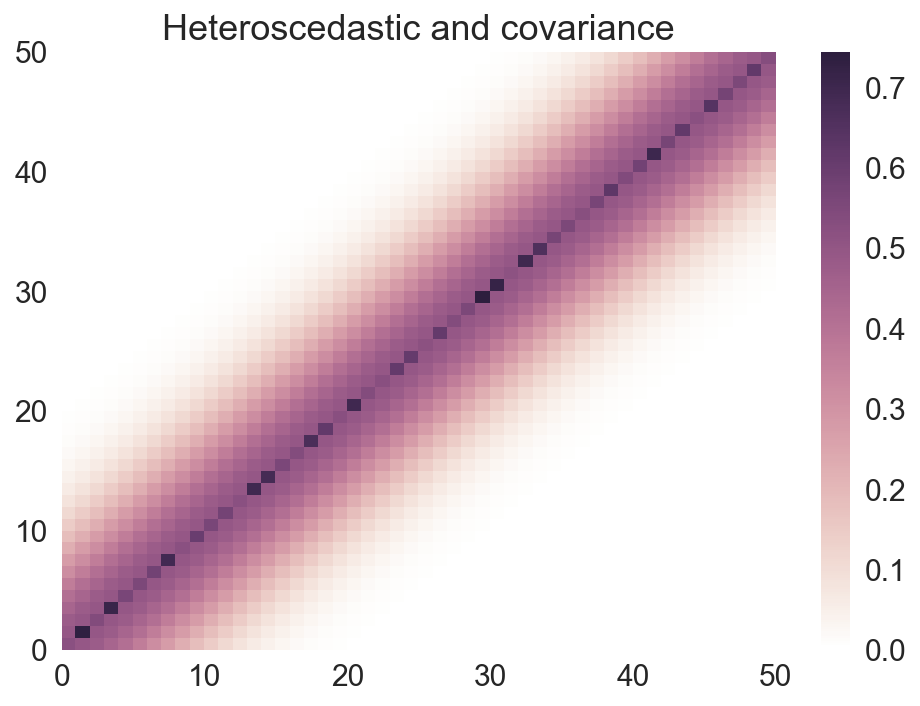

In [14]:
#Visualize the covariance
plt.pcolormesh(true_cov, cmap=cmap);
plt.colorbar();
plt.title('Heteroscedastic and covariance')

## Plot III: Data vs 'truth'
And plot the data with the observational uncertainties. The true line is plotted in black.

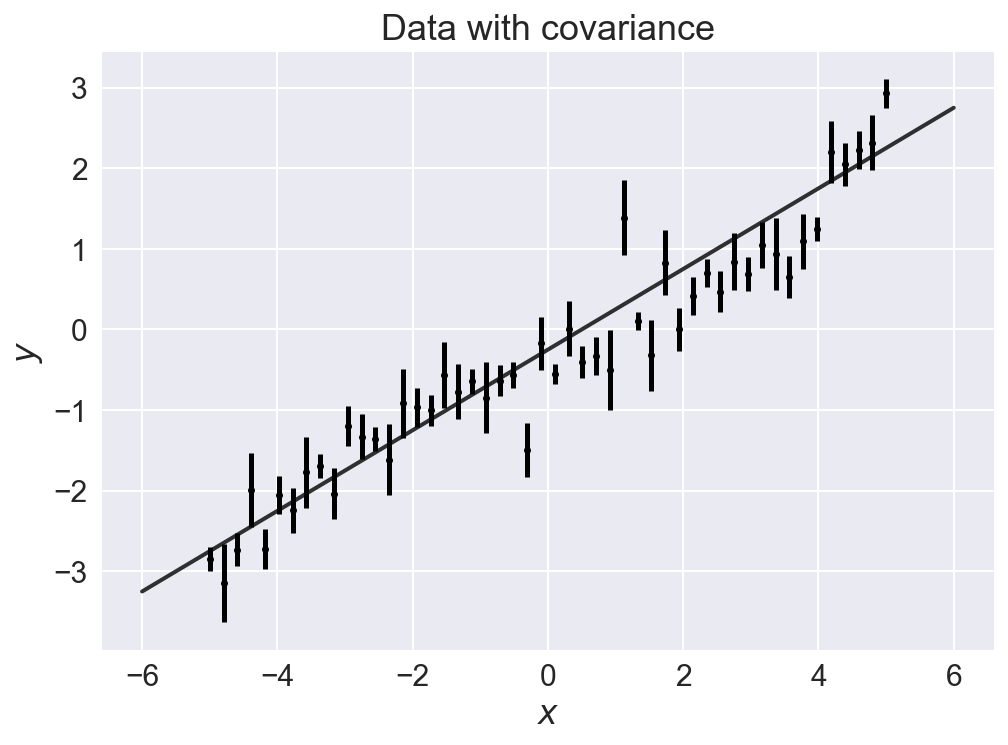

In [15]:
x0 = np.linspace(-6, 6, 1000)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, true_m * x0 + true_b, "-k", lw=2, alpha=0.8)
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.title('Data with covariance');

## Do the linear regression in Matrix form

In [16]:
A = np.vander(x, 2)
AT= A.T
C = iid_cov
C_inv = np.linalg.inv(C)
S_inv = np.dot( np.dot(AT, C_inv), A)
S= np.linalg.inv(S_inv)

ls_m, ls_b = np.linalg.solve(S_inv, np.dot(A.T, np.linalg.solve(iid_cov, y)))
ls_S = np.linalg.inv(S_inv)

In [17]:
A

array([[-5.        ,  1.        ],
       [-4.79591837,  1.        ],
       [-4.59183673,  1.        ],
       [-4.3877551 ,  1.        ],
       [-4.18367347,  1.        ],
       [-3.97959184,  1.        ],
       [-3.7755102 ,  1.        ],
       [-3.57142857,  1.        ],
       [-3.36734694,  1.        ],
       [-3.16326531,  1.        ],
       [-2.95918367,  1.        ],
       [-2.75510204,  1.        ],
       [-2.55102041,  1.        ],
       [-2.34693878,  1.        ],
       [-2.14285714,  1.        ],
       [-1.93877551,  1.        ],
       [-1.73469388,  1.        ],
       [-1.53061224,  1.        ],
       [-1.32653061,  1.        ],
       [-1.12244898,  1.        ],
       [-0.91836735,  1.        ],
       [-0.71428571,  1.        ],
       [-0.51020408,  1.        ],
       [-0.30612245,  1.        ],
       [-0.10204082,  1.        ],
       [ 0.10204082,  1.        ],
       [ 0.30612245,  1.        ],
       [ 0.51020408,  1.        ],
       [ 0.71428571,

###Plot the least squares solution as an oband

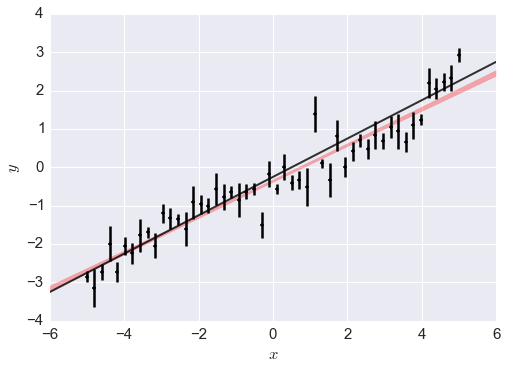

In [12]:
rand_params=np.random.multivariate_normal([ls_m, ls_b], ls_S, size=5000)
samples = np.dot(np.vander(x0, 2), rand_params.T)
ls_mu = np.mean(samples, axis=1)
ls_std = np.std(samples, axis=1)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, true_m * x0 + true_b, "k", lw=2, alpha=0.8);
plt.fill_between(x0, ls_mu+ls_std, ls_mu-ls_std, color="r", alpha=0.3)
plt.ylim(-4, 4)
plt.xlabel('$x$');
plt.ylabel('$y$');

Okay, now let's use the True Covariance matrix we have and do the same least squares.
This is sort of cheating, since the covariance matrix was used in drawing the data
in the first place.  It's important to note that we don't get back exactly the
true line when we stick in the covariance matrix though.  The y's were merely DRAWN FROM 
a multivariate normal (MVN) whose mean values were the true y's (=true_m x + true_b),
and the covariance matrix of the MVN was this True Covariance matrix, true_cov.
In the limit that we fit tons of iterations of the least squares, one of the fits
will be close to true_m, true_b, but there will be ample (honest) scatter.

In [13]:
S_inv1 = np.dot(AT, np.linalg.solve(true_cov, A))
corr_m, corr_b = np.linalg.solve(S_inv1, np.dot(AT, np.linalg.solve(true_cov, y)))
corr_S = np.linalg.inv(S_inv1)

rand_paramsCorr=np.random.multivariate_normal([corr_m, corr_b], corr_S, size=5000)

Visualize the [m, b] derived from independent error Least Squares AND 
true Correlation matrix least squares, and the true [m, b]
Put the distribution of parameters as a Hess diagram
Really, we could skip this and just plot the contours

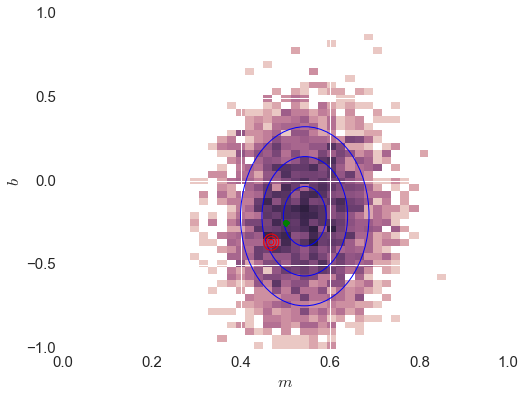

In [14]:
#Pick m, b at random

HC, xbinsC, ybinsC = np.histogram2d(rand_paramsCorr[:,0], rand_paramsCorr[:,1],
                                 bins=(np.linspace(0.0,1.0, 50),
                                       np.linspace(-1.0,1.0, 50)))
# Create a black and white color map where bad data (NaNs) are white
cmap.set_bad('w', 1.)

# Use the image display function imshow() to plot the result
fig, ax = plt.subplots(figsize=(8, 6))
HC[HC == 0] = 1  # prevent warnings in log10

ax.imshow(np.log10(HC).T, origin='lower',
          extent=[xbinsC[0], xbinsC[-1], ybinsC[0], ybinsC[-1]],
          cmap=cmap, interpolation='nearest',
          aspect='auto')          


ax.plot([ls_m], [ls_b], 'rx')  
ax.plot([corr_m], [corr_b], 'b+')      
ax.plot([true_m], [true_b], 'go')  

#From astroML book page 110 eq. 3.82
ang1=0.5*np.arctan(2.0*ls_S[1,0]/(ls_S[0,0]-ls_S[1,1]))
ang2=0.5*np.arctan(2.0*corr_S[1,0]/(corr_S[0,0]-corr_S[1,1]))

for N in (1, 2, 3):
    ax.add_patch(Ellipse([corr_m, corr_b], N * sqrt(corr_S[0,0]), N*sqrt(corr_S[1,1]),
                         angle=ang2 * 180. / np.pi, lw=1,
                         ec='b', fc='none'))

for N in (1, 2, 3):
    ax.add_patch(Ellipse(np.array([ls_m, ls_b]), N * sqrt(ls_S[0,0]), N * sqrt(ls_S[1,1]),
                         angle=ang1 * 180. / np.pi, lw=1,
                         ec='r', fc='none'))

ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$b$')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-1, 1);

Plot a nice big blue band over the data- the band is the uncertainty
surrounding a line fit, for a range of m's and b's drawn from the MVN centered on
the linear regression with the true covariance matrix 

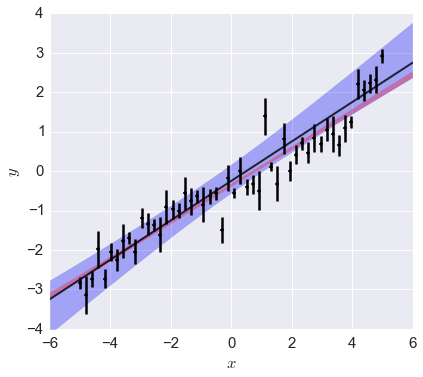

In [15]:
samples = np.dot(np.vander(x0, 2), rand_paramsCorr.T)
corr_mu = np.mean(samples, axis=1)
corr_std = np.std(samples, axis=1)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3, bottom=0.17, top=0.9)
ax = fig.add_subplot(111)

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, true_m * x0 + true_b, "k", lw=2, alpha=0.8);
ax.fill_between(x0, corr_mu+corr_std, corr_mu-corr_std, color="b", alpha=0.3)
ax.fill_between(x0, ls_mu+ls_std, ls_mu-ls_std, color="r", alpha=0.3)
plt.ylim(-4, 4)
plt.xlabel('$x$');
plt.ylabel('$y$');

Now we move on to applying a Kernel to model the off-diagonal elements
for an unknown covariance matrix!
To do that we should define some convenient functions

##Constructing a guess at the covariance matrix

The off-diagonal terms are characterized by parameters $a$ and $s$.  

The term $a$ controls the strength of the interaction.  The term $s$ controls the range of correlation.


First we define a natural log likelihood function.  You hand it an $m$, a $b$, an $a$, and an $s$ and it gives you the likelihood of the data: $\ln{p}=\ln{p(y|m,b,a,s)}$

Note: x is not passed to this function.  The way Python works, `x`, `y`, and `iid_cov` are searched for in the local namespace, then global namespace.

In [16]:
def lnlike(m, b, lna, lns):
    a, s = np.exp(lna), np.exp(lns)
    off_diag_terms = a * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    s, logdet = np.linalg.slogdet(C)
    if s <= 0:
        return -np.inf
    r = y - (m*x + b)
    return -0.5 * (np.dot(r, np.linalg.solve(C, r)) + logdet)

In [17]:
# Apply a uniform prior over some range.
# Shape params are uniform in log space 
def lnprior(m, b, lna, lns):
    if not (-2 < m < 2 and -2 < b < 2 and -5 < lna < 5 and -5 < lns < 5):
        return -np.inf
    return 0.0

In [18]:
def lnprob(p):
    lp = lnprior(*p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(*p)

## Run `emcee`!

In [19]:
ndim, nwalkers = 4, 32
p0 = np.array([true_m, true_b, np.log(0.5), np.log(1.3)]) #WTF this is cheating!!
pos = [p0 + 1.0e-2 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [20]:
# This is the burn-in
pos, lp, state = sampler.run_mcmc(pos, 300)

In [21]:
sampler.reset()
pos, lp, state = sampler.run_mcmc(pos, 5000)
chain = sampler.chain

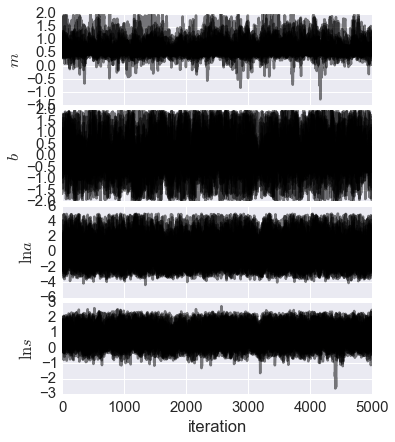

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(5, 6), sharex=True)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.96, top=0.98,
                    wspace=0.0, hspace=0.05)
[a.plot(np.arange(chain.shape[1]), chain[:, :, i].T, "k", alpha=0.5)
 for i, a in enumerate(axes)]
[a.set_ylabel("${0}$".format(l)) for a, l in zip(axes, ["m", "b", "\ln a", "\ln s"])]
axes[-1].set_xlim(0, chain.shape[1])
axes[-1].set_xlabel("iteration");

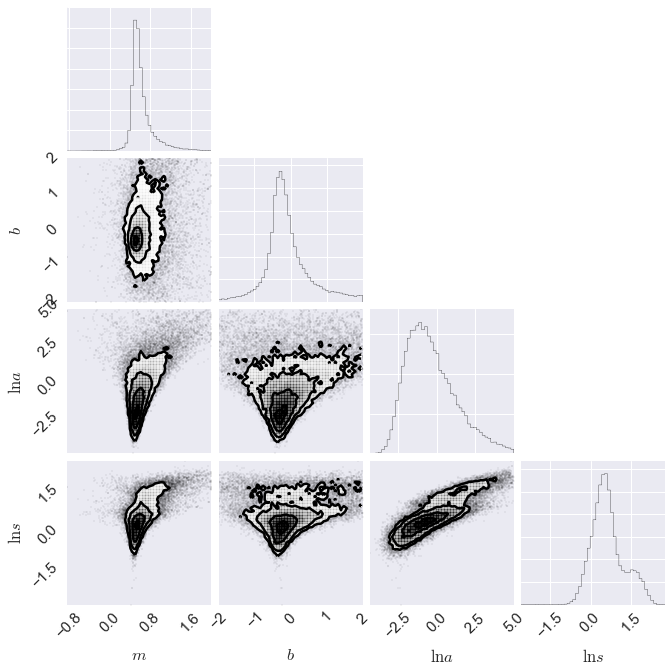

In [23]:
fig = triangle.corner(sampler.flatchain[::5], labels=map("${0}$".format, ["m", "b", "\ln a", "\ln s"]))